In [1]:
import sys
import os

# sys.path.append(os.path.abspath("../common"))

import math
import time
import numpy as np
import cv2
import pynq
import dac_sdc
import ctypes

team_name = 'iSmart'
team = dac_sdc.Team(team_name, batch_size = 64)

In [2]:
# last_bais = np.load('last_bias.npy')
# last_bais = last_bais.reshape((6, 6))[:, :4]
# os.system('g++ -shared -O3 ./load_image_pingpong2.cpp -o load_image_pingpong2.so -fPIC $(pkg-config opencv --cflags --libs) -lpthread')

os.system('g++ -shared -O3 ./load_image_pingpong3.cpp -fpermissive -o load_image_pingpong3.so -fPIC $(pkg-config opencv --cflags --libs) -lpthread')

# cfuns = ctypes.cdll.LoadLibrary("./load_image_new3.so")
# cfuns = ctypes.cdll.LoadLibrary("./load_image_new.so")
# cfuns = ctypes.cdll.LoadLibrary("./load_image_pingpong.so")
cfuns = ctypes.cdll.LoadLibrary("./load_image_pingpong3.so")
# cfuns = ctypes.cdll.LoadLibrary("./load_image_3p16.so")

overlay = pynq.Overlay(team.get_bitstream_path())
dma = overlay.axi_dma_0
xlnk = pynq.Xlnk()
nn_ctrl = overlay.ultra_net_0
print('got nn accelerator!')

got nn accelerator!


In [3]:
BATCH_SIZE = team.batch_size
IMAGE_RAW_ROW = 360
IMAGE_RAW_COL = 640
IMAGE_ROW = 160
IMAGE_COL = 320
GRID_ROw = 10
GRID_COL = 20
X_SCALE = IMAGE_RAW_COL / IMAGE_COL
Y_SCALE = IMAGE_RAW_ROW / IMAGE_ROW


in_buffer0 = xlnk.cma_array(shape=(BATCH_SIZE, IMAGE_RAW_ROW, IMAGE_RAW_COL, 3), dtype=np.uint8, cacheable = 1)
in_buffer1 = xlnk.cma_array(shape=(BATCH_SIZE, IMAGE_RAW_ROW, IMAGE_RAW_COL, 3), dtype=np.uint8, cacheable = 1)
in_buffers = [in_buffer0, in_buffer1]
out_buffer0 = xlnk.cma_array(shape=(BATCH_SIZE, GRID_ROw, GRID_COL, 6, 6), dtype=np.int32, cacheable = 1)
out_buffer1 = xlnk.cma_array(shape=(BATCH_SIZE, GRID_ROw, GRID_COL, 6, 6), dtype=np.int32, cacheable = 1)
out_buffers = [out_buffer0, out_buffer1]


# use c code load image
def load_image(image_paths, buff):
    ts = time.time()
    paths = [str(path) for path in image_paths]
    tmp = np.asarray(buff)
    dataptr = tmp.ctypes.data_as(ctypes.c_char_p)
    paths_p_list = [ctypes.c_char_p(bytes(str_, 'utf-8')) for str_ in paths]
    paths_c = (ctypes.c_char_p*len(paths_p_list))(*paths_p_list)
    cfuns.load_image(paths_c, dataptr, len(paths), IMAGE_ROW, IMAGE_COL, 3)
    return time.time() - ts
    
def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

def yolo(out_buffer, batch_n,_,result):
    out_buffer_dataptr=out_buffer.ctypes.data_as(ctypes.c_char_p)
    rst=np.empty( (batch_n,4),dtype=np.int32)
    rst_dataptr=rst.ctypes.data_as(ctypes.c_char_p)
    cfuns.yolo(out_buffer_dataptr,batch_n,rst_dataptr)
    result.extend(rst.tolist())

# def yolo(out_buffer, batch_n, div, result=None):
#     res_np = np.array(out_buffer[:batch_n]).reshape(batch_n, -1, 6, 6)
#     conf = res_np[...,4].sum(axis=2)
#     max_index = conf.argmax(1)
    
#     grid_x = max_index % GRID_COL
#     grid_y = max_index // GRID_COL
    
#     boxs = np.zeros((batch_n, 6, 4))
#     for i in range(batch_n):
#         boxs[i, :, :] = res_np[i, max_index[i], :, :4] / div
#     xy = sigmoid(boxs[..., :2]).mean(axis=1)
#     wh = np.exp(boxs[..., 2:4]).mean(axis=1)
    
#     xy[:, 0] += grid_x
#     xy[:, 1] += grid_y

#     xy *= 16
#     wh *= 20

#     xy[:, 0] *= X_SCALE
#     xy[:, 1] *= Y_SCALE
#     wh[:, 0] *= X_SCALE
#     wh[:, 1] *= Y_SCALE
#     xmin = xy[:, 0] - wh[:, 0] / 2
#     xmax = xy[:, 0] + wh[:, 0] / 2
#     ymin = xy[:, 1] - wh[:, 1] / 2
#     ymax = xy[:, 1] + wh[:, 1] / 2
    
#     for i in range(batch_n):
#         temp = [int(xmin[i]), int(xmax[i]), int(ymin[i]), int(ymax[i])]
# #         temp = [0, 0, 0, 0]
#         result.append(temp)
# #         result.append([0,0,0,0])
    
which_buffer = 0
first_batch = True
net_cnt = 0
last_batch_size = BATCH_SIZE

def net(img_paths, result):
    global first_batch
    global which_buffer    
    global net_cnt
    global last_batch_size
#     load_img_time = 0
    # buffer first batch
    if first_batch == True:
        first_batch = False
        which_buffer = 0
        load_image(img_paths, in_buffers[which_buffer])
#         load_img_time += load_image(img_paths, in_buffers[which_buffer])
        return
    # count
    net_cnt += 1
    nn_ctrl.write(0x0, 0) # Reset
    nn_ctrl.write(0x10, in_buffers[which_buffer].shape[0])
    nn_ctrl.write(0x0, 1) # Deassert reset
    

    dma.recvchannel.transfer(out_buffers[which_buffer])
    dma.sendchannel.transfer(in_buffers[which_buffer])

    
    # switch buffer
    if which_buffer == 0:
        which_buffer = 1
    else:
        which_buffer = 0
    # buffer next batch

    if img_paths is not None:
        load_image(img_paths, in_buffers[which_buffer])
#         load_img_time += load_image(img_paths, in_buffers[which_buffer])

    
    # yolo 
    if net_cnt > 1:
#         yolo(out_buffers[which_buffer], BATCH_SIZE, 7 * 15, result)
        yolo(out_buffers[which_buffer], BATCH_SIZE, 127 * 15, result)
    
    if img_paths is not None and len(img_paths) != BATCH_SIZE:
        last_batch_size = len(img_paths)

    dma.sendchannel.wait()
    dma.recvchannel.wait()

    # last batch 
    if img_paths is None:
#         yolo(out_buffers[(which_buffer + 1) % 2], last_batch_size, 7 * 15, result) # 4-bit
        yolo(out_buffers[(which_buffer + 1) % 2], last_batch_size, 127 * 15, result) # 8-bit


#     print(load_img_time)
#     return load_img_time

In [4]:

from multiprocessing import Process, Pipe, Queue, Event, Manager, Lock, Value
        
time_list = []
fps_list = []
energy_list = []
num_rounds = 1
################################Inference##################################
for i in range(num_rounds):
    print('Testing round #%d'%(i+1))
    interval_time = 0
    total_time = 0
    total_energy = 0
    result = list()
    team.reset_batch_count()

    rails = pynq.get_rails()

    load_time = 0
    start = time.time()
    recorder = pynq.DataRecorder(rails["5V"].power)
    with recorder.record(0.05):
        while True:
            image_paths = team.get_next_batch()
            net(image_paths, result)
    #         net_time = net(image_paths, result)
    #         load_time += net_time
    #         print(net_time)

    #         print('pro_image_cnt', len(result))
            # end
            if image_paths is None:
                break

    end = time.time()
    t = end - start

    # Energy measurements    
    energy = recorder.frame["5V_power"].mean() * t    
    # energy = 0

    total_time = t
    total_energy = energy
    time_list.append(total_time)
    energy_list.append(total_energy)
    fps_list.append(len(result) / total_time)
    team.save_results_xml(result, total_time, energy)
    print("Total time:", total_time, "seconds")
    # print("Load img time:", load_time, "seconds")
    print("Total energy:", total_energy, "J")
    print('images nums: {} .'.format(len(result)))
    print('fps: {} .'.format(len(result) / total_time))
    print()

Testing round #1

All results stored in bbox_PL_1000_sample.txt
Total time: 3.681396722793579 seconds
Total energy: 17.3246011268 J
images nums: 1000 .
fps: 271.63603254396423 .



In [5]:
xlnk.xlnk_reset()

In [6]:
time_std = np.std(time_list)
print('Time Std. Dev.:', time_std)
energy_std = np.std(energy_list)
print('Energy Std. Dev.:', energy_std)
fps_std = np.std(fps_list)
print('FPS Std. Dev.:', fps_std)

time_mean = np.mean(time_list)
print('Time Mean:', time_mean)
energy_mean = np.mean(energy_list)
print('Energy Mean:', energy_mean)
fps_mean = np.mean(fps_list)
print('FPS Mean:', fps_mean)

outliers = []
for i in range(num_rounds):
    if abs(time_list[i] - time_mean) > 2*time_std or abs(energy_list[i] - energy_mean) > 2*energy_std or abs(fps_list[i] - fps_mean) > 2*fps_std:
        print('Outside 2-std:',i)
        
        outliers.append([time_list[i], energy_list[i], fps_list[i]])
    
time_list_new = time_list.copy()
energy_list_new = energy_list.copy()
fps_list_new = fps_list.copy()
for outlier in outliers:
    time_list_new.remove(outlier[0])
    energy_list_new.remove(outlier[1])
    fps_list_new.remove(outlier[2])
        
time_std = np.std(time_list_new)
print('Time Std. Dev. (Outlier removed):', time_std)
energy_std = np.std(energy_list_new)
print('Energy Std. Dev. (Outlier removed):', energy_std)
fps_std = np.std(fps_list_new)
print('FPS Std. Dev. (Outlier removed):', fps_std)

time_mean = np.mean(time_list_new)
print('Time Mean (Outlier removed):', time_mean)
energy_mean = np.mean(energy_list_new)
print('Energy Mean (Outlier removed):', energy_mean)
fps_mean = np.mean(fps_list_new)
print('FPS Mean (Outlier removed):', fps_mean)

Time Std. Dev.: 0.0
Energy Std. Dev.: 0.0
FPS Std. Dev.: 0.0
Time Mean: 3.68139672279
Energy Mean: 17.3246011268
FPS Mean: 271.636032544
Time Std. Dev. (Outlier removed): 0.0
Energy Std. Dev. (Outlier removed): 0.0
FPS Std. Dev. (Outlier removed): 0.0
Time Mean (Outlier removed): 3.68139672279
Energy Mean (Outlier removed): 17.3246011268
FPS Mean (Outlier removed): 271.636032544


In [7]:
import matplotlib.pyplot as plt

num_rounds_new = len(time_list_new)
x_range = np.arange(1, num_rounds_new+1)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 9), dpi=300)

ax1.plot(x_range, time_list_new,'b')
ax1.plot(x_range, [np.mean(time_list_new) for i in range(num_rounds_new)],'y-.')
ax1.set_ylabel('Inference Time',fontsize=12)
ax1.set_title('100 MHz')
# ax1.set_xlabel('Testing Round',fontsize=12)
ax2.plot(x_range, energy_list_new,'r')
ax2.plot(x_range, [np.mean(energy_list_new) for i in range(num_rounds_new)],'y-.')
ax2.set_ylabel('Inference Energy',fontsize=12)
# ax2.set_xlabel('Testing Round',fontsize=12)
ax3.plot(x_range, fps_list_new,'g')
ax3.plot(x_range, [np.mean(fps_list_new) for i in range(num_rounds_new)],'y-.')
ax3.set_ylabel('Inference FPS',fontsize=12)
ax3.set_xlabel('Testing Round',fontsize=12)

# plt.savefig('crosse_results.png')
plt.show()

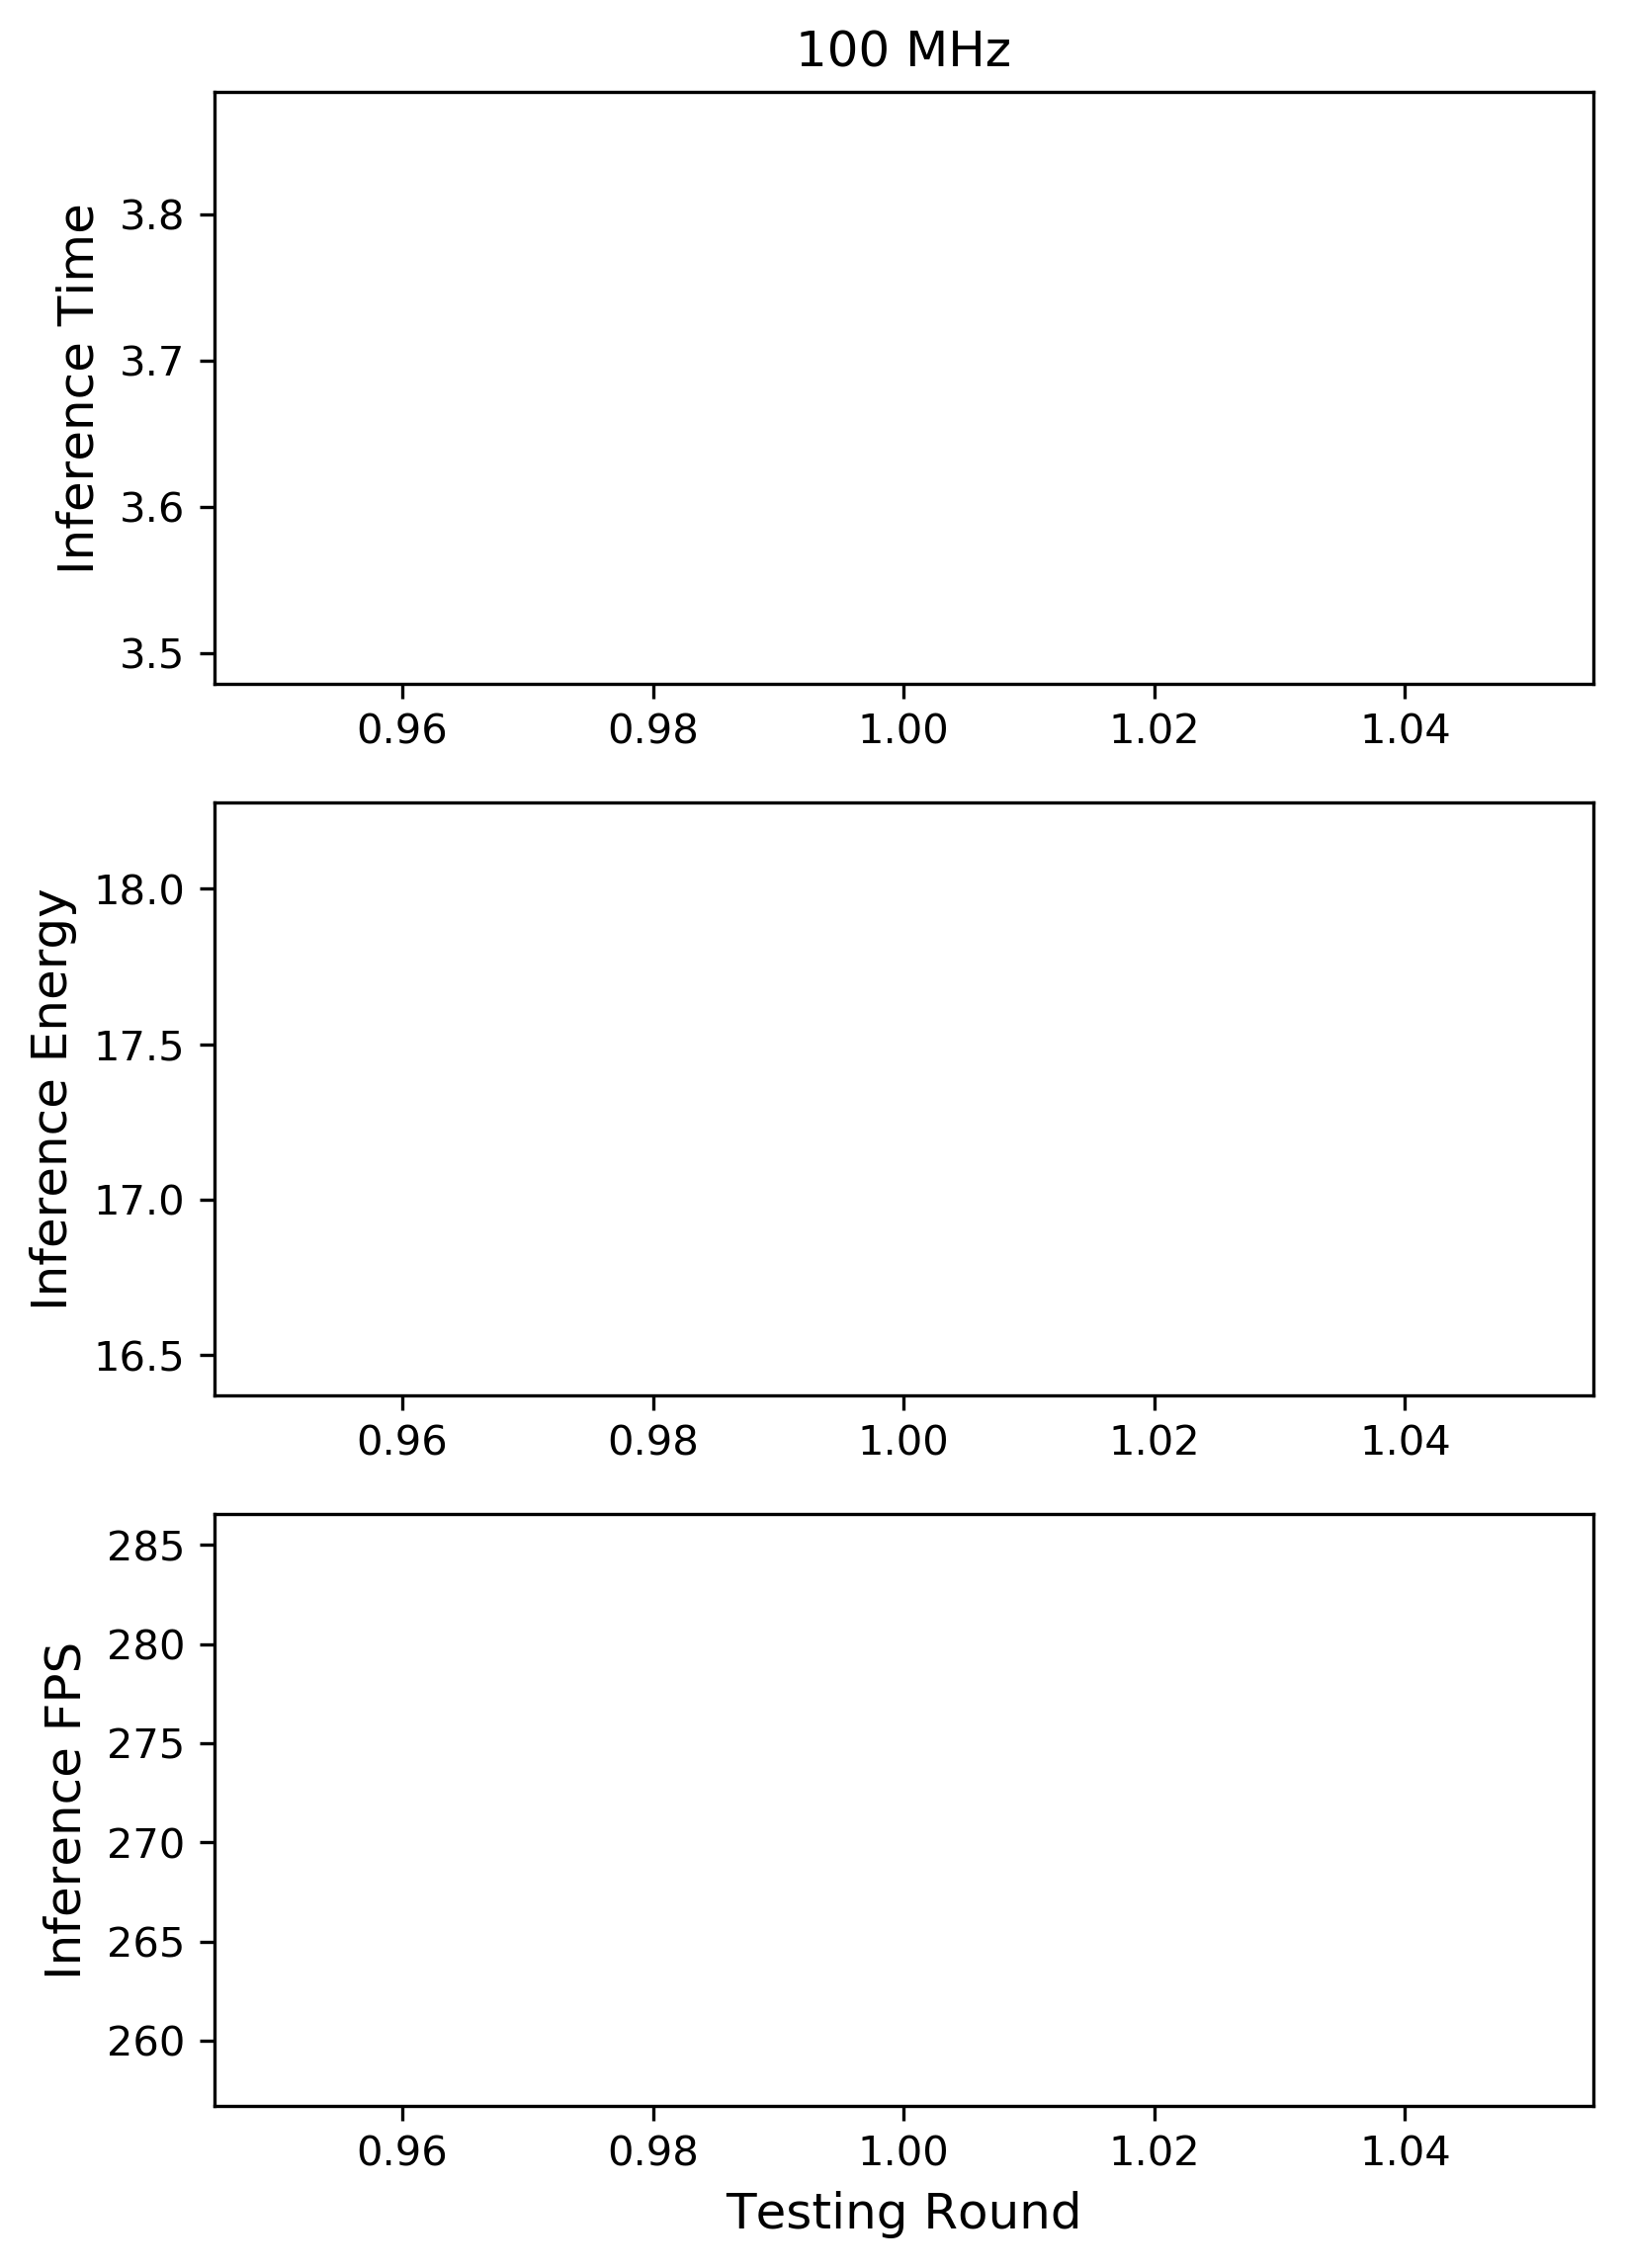

In [8]:
num_rounds_new = len(time_list)
x_range = np.arange(1, num_rounds_new+1)
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 9), dpi=300)

ax1.plot(x_range, time_list,'b')
ax1.plot(x_range, [np.mean(time_list) for i in range(num_rounds_new)],'y-.')
ax1.set_ylabel('Inference Time',fontsize=12)
ax1.set_title('100 MHz')
# ax1.set_xlabel('Testing Round',fontsize=12)
ax2.plot(x_range, energy_list,'r')
ax2.plot(x_range, [np.mean(energy_list) for i in range(num_rounds_new)],'y-.')
ax2.set_ylabel('Inference Energy',fontsize=12)
# ax2.set_xlabel('Testing Round',fontsize=12)
ax3.plot(x_range, fps_list,'g')
ax3.plot(x_range, [np.mean(fps_list) for i in range(num_rounds_new)],'y-.')
ax3.set_ylabel('Inference FPS',fontsize=12)
ax3.set_xlabel('Testing Round',fontsize=12)

# plt.savefig('crosse_results.png')
plt.show()

In [9]:
def computeIoU(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    if( xB < xA or yB < yA ):
        return 0.0

    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou



#f_PL = open("iSmart2.txt", "r")
f_PL = open("./bbox_PL_1000_sample.txt", "r")
#f_PL = open("bbox_PL_1000.txt", "r")
#f_PL = open("bbox_PL_1000_sample_64_py2.txt", "r")
#f_PL = open("bbox_golden_c_1000_sample_512_py3.txt", "r")
#f_PL = open("bbox_golden_c_1000.txt", "r")
f_GT = open("../deploy/bbox_GT_1000_sample.txt", "r")
#f_GT = open("bbox_GT_1000.txt", "r")

#f_PL = open("bbox_pytorch.txt", "r")
#f_PL = open("bbox_golden_C.txt", "r")

bbox_PL = []
bbox_GT = []


for line in f_PL:
    if not line.strip():
        continue
    if(line.endswith("jpg\n") or line.endswith("xml\n") or line.endswith("bin\n")):
        continue
        
    x1, x2, y1, y2 = line.split()
    bbox_PL.append([int(x1), int(y1), int(x2), int(y2)])
    


for line in f_GT:
    if not line.strip():
        continue
    if(line.endswith("jpg\n") or line.endswith("xml\n") or line.endswith("bin\n")):
        continue
        
    x1, x2, y1, y2 = line.split()
    bbox_GT.append([int(x1), int(y1), int(x2), int(y2)])
    

#if( len(bbox_PL) != len(bbox_GT) ):
#    print("ERROR! Ground truth and PL output do not match!")
    
cnt = len(bbox_PL)
IoU_avg = 0
for i in range(cnt):
    boxA = bbox_PL[i]
    boxB = bbox_GT[i]
    
    print('\n')
    print(i)
    print(boxA)
    print(boxB)
    
    IoU = computeIoU(boxA, boxB)
    print(IoU)
    
    IoU_avg = IoU_avg + IoU

print("\nAvg IOU:")
print(IoU_avg/cnt)




0
[300, 133, 381, 235]
[295, 131, 382, 232]
0.8891780524831924


1
[293, 131, 314, 172]
[294, 129, 314, 173]
0.8936170212765957


2
[560, 235, 574, 248]
[560, 235, 573, 252]
0.7368421052631579


3
[238, 160, 260, 212]
[239, 161, 262, 216]
0.8062015503875969


4
[303, 168, 320, 198]
[301, 170, 324, 200]
0.6692307692307692


5
[236, 292, 247, 321]
[235, 293, 245, 322]
0.725


6
[173, 34, 217, 161]
[173, 35, 219, 158]
0.9287616511318242


7
[260, 85, 304, 197]
[260, 87, 304, 196]
0.9734513274336283


8
[208, 94, 246, 195]
[208, 95, 244, 194]
0.930115635997989


9
[305, 284, 323, 310]
[304, 281, 323, 309]
0.8247078464106845


10
[319, 153, 345, 230]
[318, 153, 346, 228]
0.9087688219663419


11
[322, 149, 340, 169]
[317, 147, 339, 174]
0.5684210526315789


12
[316, 156, 338, 176]
[317, 157, 339, 176]
0.8747514910536779


13
[328, 152, 357, 219]
[333, 149, 358, 211]
0.6887052341597796


14
[210, 95, 273, 289]
[209, 100, 269, 291]
0.8911819887429644


15
[435, 193, 479, 232]
[438, 191, 479,

179
[250, 152, 275, 197]
[250, 152, 276, 199]
0.9228395061728395


180
[324, 175, 340, 191]
[344, 177, 345, 183]
0.0


181
[200, 171, 236, 203]
[243, 163, 276, 200]
0.0


182
[202, 24, 243, 148]
[202, 24, 243, 145]
0.976


183
[312, 175, 342, 222]
[310, 173, 335, 225]
0.6721120186697783


184
[304, 139, 330, 203]
[306, 140, 330, 196]
0.811965811965812


185
[237, 305, 308, 359]
[209, 142, 291, 222]
0.0


186
[306, 140, 329, 198]
[308, 142, 332, 198]
0.7901701323251418


187
[312, 163, 335, 209]
[314, 160, 336, 211]
0.8015503875968992


188
[288, 151, 338, 298]
[293, 166, 335, 289]
0.7064122946475888


189
[325, 171, 358, 257]
[323, 172, 358, 259]
0.9131792629606496


190
[560, 165, 568, 178]
[561, 165, 568, 177]
0.8253968253968254


191
[225, 319, 239, 348]
[226, 320, 236, 353]
0.6316831683168317


192
[304, 159, 333, 234]
[307, 157, 335, 239]
0.7787476280834915


193
[317, 148, 333, 170]
[323, 150, 338, 171]
0.451171875


194
[303, 240, 327, 280]
[299, 169, 321, 200]
0.0


195
[271, 1


379
[290, 146, 327, 216]
[292, 148, 325, 212]
0.8191252779836916


380
[292, 128, 310, 181]
[290, 131, 308, 182]
0.7558849171752398


381
[315, 5, 340, 63]
[315, 6, 341, 64]
0.9314391599752934


382
[245, 156, 269, 205]
[245, 153, 271, 200]
0.7916959887403238


383
[321, 29, 414, 140]
[330, 33, 405, 137]
0.7579787234042553


384
[302, 118, 367, 271]
[307, 119, 372, 276]
0.8289368505195843


385
[306, 172, 337, 213]
[309, 166, 333, 216]
0.6692160611854685


386
[315, 153, 342, 222]
[316, 150, 342, 226]
0.8794788273615635


387
[183, 211, 246, 356]
[186, 212, 249, 360]
0.8814150473343298


388
[327, 171, 348, 201]
[323, 172, 346, 200]
0.7268170426065163


389
[304, 167, 324, 200]
[303, 168, 325, 199]
0.8637532133676092


390
[191, 183, 228, 274]
[206, 140, 295, 226]
0.09811906146984681


391
[363, 22, 438, 137]
[361, 29, 433, 131]
0.8105741520727111


392
[329, 130, 336, 144]
[331, 133, 335, 146]
0.46153846153846156


393
[291, 12, 311, 65]
[290, 9, 313, 64]
0.8153846153846154


394
[37

0.8221859706362153


579
[243, 126, 305, 279]
[234, 124, 312, 278]
0.7831491712707183


580
[301, 144, 347, 242]
[296, 131, 351, 242]
0.7418686224489796


581
[168, 63, 289, 174]
[175, 67, 286, 173]
0.8770491803278688


582
[298, 119, 319, 162]
[298, 117, 319, 162]
0.9565217391304348


583
[293, 149, 336, 204]
[306, 161, 336, 196]
0.45292207792207795


584
[294, 6, 339, 25]
[291, 8, 337, 30]
0.6550868486352357


585
[324, 148, 344, 172]
[329, 153, 345, 174]
0.5526770293609672


586
[286, 158, 305, 197]
[289, 161, 307, 200]
0.6756176154672395


587
[326, 130, 347, 182]
[328, 132, 345, 182]
0.7873070325900514


588
[299, 149, 332, 214]
[296, 148, 329, 212]
0.8032388663967611


589
[372, 125, 394, 178]
[374, 126, 393, 177]
0.8373590982286635


590
[306, 142, 359, 271]
[303, 145, 359, 269]
0.9127789046653144


591
[369, 189, 392, 246]
[364, 190, 390, 246]
0.7477638640429338


592
[377, 96, 403, 156]
[377, 95, 405, 155]
0.9020044543429844


593
[326, 171, 351, 234]
[328, 164, 350, 231]
0.76

[247, 152, 273, 199]
0.8543833580980683


779
[316, 147, 355, 207]
[314, 149, 349, 211]
0.7424130273871207


780
[329, 105, 343, 148]
[327, 105, 343, 151]
0.8260325406758448


781
[327, 190, 344, 213]
[329, 190, 343, 215]
0.7792207792207793


782
[306, 122, 319, 162]
[307, 123, 319, 163]
0.8858603066439523


783
[304, 173, 340, 228]
[295, 172, 340, 232]
0.7384176764076978


784
[351, 158, 384, 210]
[355, 158, 373, 201]
0.46392896781354054


785
[315, 134, 357, 204]
[311, 139, 357, 195]
0.7470283450167632


786
[310, 181, 333, 209]
[308, 179, 330, 206]
0.6876574307304786


787
[366, 180, 390, 216]
[367, 185, 393, 214]
0.7093596059113301


788
[295, 169, 320, 208]
[297, 173, 319, 204]
0.7076923076923077


789
[299, 149, 321, 204]
[298, 149, 321, 204]
0.9583333333333334


790
[377, 321, 425, 359]
[384, 323, 416, 359]
0.6389324960753532


791
[275, 111, 287, 149]
[276, 112, 287, 151]
0.8587570621468926


792
[166, 231, 239, 307]
[180, 164, 369, 300]
0.15257192676547515


793
[299, 149, 323

[302, 161, 328, 185]
[303, 163, 331, 181]
0.674863387978142


979
[251, 161, 291, 292]
[252, 161, 288, 283]
0.8409090909090909


980
[235, 131, 268, 213]
[230, 119, 275, 210]
0.6275957544993078


981
[306, 176, 330, 204]
[306, 175, 328, 202]
0.8302139037433155


982
[271, 151, 296, 196]
[273, 150, 299, 197]
0.7953890489913544


983
[351, 158, 386, 215]
[349, 154, 380, 216]
0.7360406091370558


984
[258, 151, 349, 202]
[258, 162, 342, 198]
0.6573996655518395


985
[338, 156, 363, 209]
[331, 154, 361, 213]
0.6585365853658537


986
[216, 146, 326, 275]
[219, 147, 331, 273]
0.9104546963159642


987
[296, 169, 321, 209]
[300, 172, 322, 203]
0.6411657559198543


988
[275, 100, 287, 136]
[276, 101, 286, 136]
0.8232848232848233


989
[397, 283, 424, 298]
[397, 284, 424, 299]
0.8823529411764706


990
[75, 196, 108, 255]
[74, 191, 108, 254]
0.882145998240985


991
[350, 143, 379, 201]
[348, 142, 382, 204]
0.8027210884353742


992
[292, 155, 343, 208]
[293, 155, 339, 206]
0.8703703703703703


993